<a href="https://colab.research.google.com/github/jayeshsc/18CSE301J_RA2011028010094/blob/main/Chapter4_Panchatantra_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

import string

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
df = pd.read_excel("Panchatantra_Data.xlsx")

In [9]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [10]:
df.head()

,Title,Chapter,Story,Strategy,BookNumber
0,The Separation of Friends,1,"Long ago in a village in South India, there li...",Mitra-bheda: The Separation of Friends,1
1,The Monkey and the Wedge,2,Once a merchant began building a temple in his...,Mitra-bheda: The Separation of Friends,1
2,The Jackal and the Drum,3,A hungry jackal ended up at an abandoned battl...,Mitra-bheda: The Separation of Friends,1
3,The Fall and Rise of a Merchant,4,"Once, there lived a wealthy merchant named Dan...",Mitra-bheda: The Separation of Friends,1
4,The Foolish Sage and the Jackal,5,There lived a sage named Deva Sharma in a mona...,Mitra-bheda: The Separation of Friends,1


In [11]:
#Remove punctuation
stopwords = [''.join(item for item in x if item not in string.punctuation) for x in stopwords] 

df['WordCountText']=df['Story'].str.lower().apply(remove_punctuations).apply(word_tokenize)
# Word Count
df['WordCloudText']=df['WordCountText'].apply(lambda x: [word for word in x if word not in stopwords]) 
df['WordCount'] = df['WordCountText'].str.len()

In [12]:
# Creating a table breaking down the text by each sentence

dfsentiment = df[['Story', 'BookNumber', 'Chapter']].reset_index() \
    .drop(["index"], axis=1)
dfsentiment = dfsentiment.join(dfsentiment.Story.apply(sent_tokenize).rename('Sentences')) 

dfsentiment2 = dfsentiment.Sentences.apply(pd.Series) \
    .merge(dfsentiment, left_index = True, right_index = True) \
    .drop(["Story"], axis = 1) \
    .drop(["Sentences"], axis = 1) \
    .melt(id_vars = ['Chapter', 'BookNumber'], value_name = "Sentence") \
    .drop("variable", axis = 1) \
    .dropna()

dfsentiment2=dfsentiment2.sort_values(by=['Chapter', 'BookNumber']) \
    .reset_index() \
    .drop(['index'], axis = 1)

dfsentiment2['Sentence']=dfsentiment2.Sentence.apply(remove_punctuations).apply(lambda x: x.lower()) 

In [13]:
dfsentiment2

,Chapter,BookNumber,Sentence
0,1,1,long ago in a village in south india there liv...
1,1,1,one day while resting on his bed he realized t...
2,1,1,he convinced himself that even enemies seek th...
3,1,1,money makes the old become young while even th...
4,1,1,he logically thought that business was one of ...
...,...,...,...
3531,22,1,there is no point in fearing death because it ...
3532,22,1,one cannot escape it
3533,22,1,with these thoughts on his mind the brahmin th...
3534,22,1,the thugs accepted the offer and found nothing...


In [14]:
dfsentiment.Sentences.apply(lambda x: len(x)).sum()

3536

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import nltk
nltk.download('vader_lexicon')

sid=nltk.sentiment.vader.SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [16]:
# Get intensity scores per sentence
dfsentiment2['Score']=dfsentiment2.Sentence.apply(lambda x: sid.polarity_scores(x))

dfsentiment2['CompoundScore']=dfsentiment2.Score.apply(lambda x: x.get("compound"))
dfsentiment2['PositiveScore']=dfsentiment2.Score.apply(lambda x: x.get("positive"))
dfsentiment2['NegativeScore']=dfsentiment2.Score.apply(lambda x: x.get("negative"))
dfsentiment2['NeutralScore']=dfsentiment2.Score.apply(lambda x: x.get("neutral"))

dfsentiment2 = dfsentiment2.drop(["Score"], axis=1)

dfsentiment2['PositiveFlag'] = dfsentiment2.CompoundScore.apply(lambda x: 1 if x >= 0.05 else 0)
dfsentiment2['NegativeFlag'] = dfsentiment2.CompoundScore.apply(lambda x: 1 if x <= -0.05 else 0)
dfsentiment2['NeutralFlag'] = dfsentiment2.CompoundScore.apply(lambda x: 1 if x < 0.05 and x > -0.05 else 0)

# Confirm scores are present and flag is functional
dfsentiment2.head(20)

dfsentiment2.iloc[3000].Sentence

dfsentiment2.groupby('BookNumber').mean()['CompoundScore']

BookNumber
1   -0.018707
2    0.069727
3   -0.040799
4    0.013179
5    0.015234
Name: CompoundScore, dtype: float64

In [17]:
print('There are', dfsentiment2['PositiveFlag'].sum(), "positive sentences,", \
      dfsentiment2['NegativeFlag'].sum(), "negative sentences, and", \
      dfsentiment2['NeutralFlag'].sum(), "neutral sentences")
print('This is a total of', \
      dfsentiment2['PositiveFlag'].sum()+dfsentiment2['NegativeFlag'].sum()+dfsentiment2['NeutralFlag'].sum(), "sentences")

There are 1157 positive sentences, 1100 negative sentences, and 1279 neutral sentences
This is a total of 3536 sentences


/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


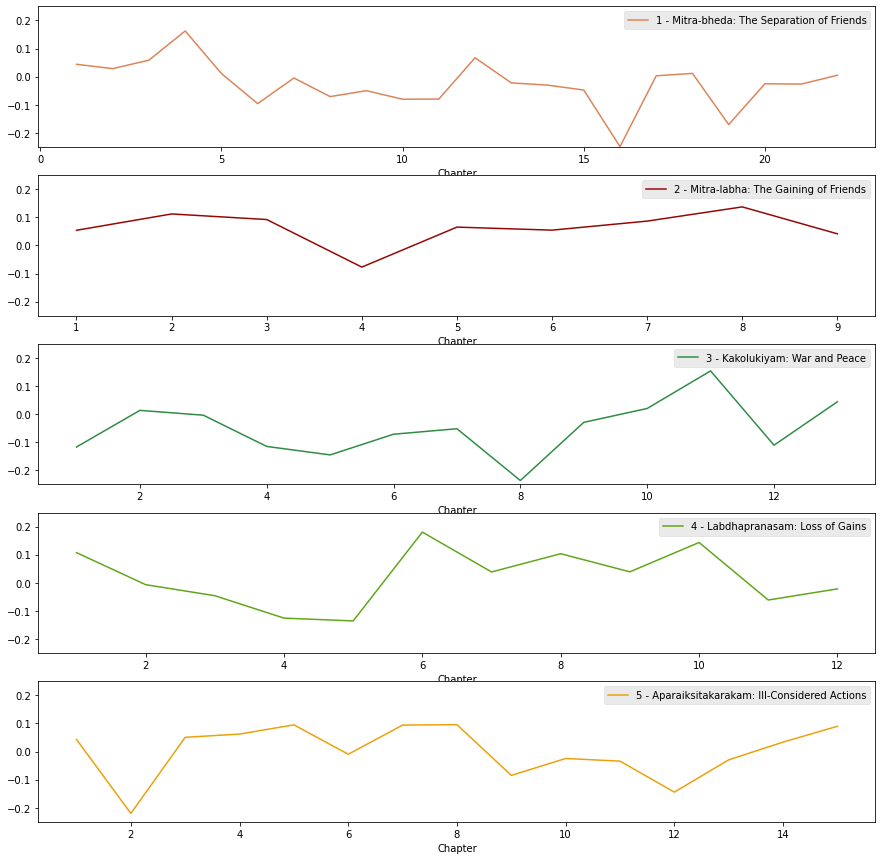

In [18]:
# How does the sentiment change during each chapter of each book over time?

def Titles(x):
    if x == 1:
        return "1 - Mitra-bheda: The Separation of Friends"
    if x == 2:
        return "2 - Mitra-labha: The Gaining of Friends"
    if x == 3:
        return "3 - Kakolukiyam: War and Peace"
    if x == 4:
        return "4 - Labdhapranasam: Loss of Gains"
    if x == 5:
        return "5 - Aparaiksitakarakam: Ill-Considered Actions"

dfsentiment2['BookTitle']=dfsentiment2.BookNumber.apply(lambda x: Titles(x))

colorsList = ['#DC8458', '#950702', '#8E067D', '#2E8C44', '#395196', '#60A619','#ECA10A']
ColorMap = matplotlib.colors.ListedColormap(colorsList)

# plot data
fig, ax = plt.subplots(figsize=(15,15))
# use unstack()
dfsentiment2.groupby(['Chapter','BookTitle']).mean()['CompoundScore'].unstack().plot(ax=ax, subplots=True, ylim=(-0.25, 0.25), colormap=ColorMap)
plt.style.use('ggplot')
ax.set_ylabel('Compound Sentiment Score')

[ax.legend(loc=1) for ax in plt.gcf().axes]

plt.savefig('PanchatantraTimeplot.png')


# Part 2

In [19]:
df.head()

,Title,Chapter,Story,Strategy,BookNumber,WordCountText,WordCloudText,WordCount
0,The Separation of Friends,1,"Long ago in a village in South India, there li...",Mitra-bheda: The Separation of Friends,1,"[long, ago, in, a, village, in, south, india, ...","[long, ago, village, south, india, lived, merc...",359
1,The Monkey and the Wedge,2,Once a merchant began building a temple in his...,Mitra-bheda: The Separation of Friends,1,"[once, a, merchant, began, building, a, temple...","[merchant, began, building, temple, garden, ma...",679
2,The Jackal and the Drum,3,A hungry jackal ended up at an abandoned battl...,Mitra-bheda: The Separation of Friends,1,"[a, hungry, jackal, ended, up, at, an, abandon...","[hungry, jackal, ended, abandoned, battlefield...",762
3,The Fall and Rise of a Merchant,4,"Once, there lived a wealthy merchant named Dan...",Mitra-bheda: The Separation of Friends,1,"[once, there, lived, a, wealthy, merchant, nam...","[lived, wealthy, merchant, named, dantila, cit...",884
4,The Foolish Sage and the Jackal,5,There lived a sage named Deva Sharma in a mona...,Mitra-bheda: The Separation of Friends,1,"[there, lived, a, sage, named, deva, sharma, i...","[lived, sage, named, deva, sharma, monastry, s...",896


In [20]:
df.Strategy.value_counts()

Mitra-bheda: The Separation of Friends       22
Apariksitakarakam: Ill-Considered Actions    15
Kakolukiyam: War and Peace                   13
Labdhapranasam: Loss of Gains                12
Mitra-labha: The Gaining of Friends           9
Name: Strategy, dtype: int64

In [21]:
plt.rcParams["figure.figsize"] = (15,10)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

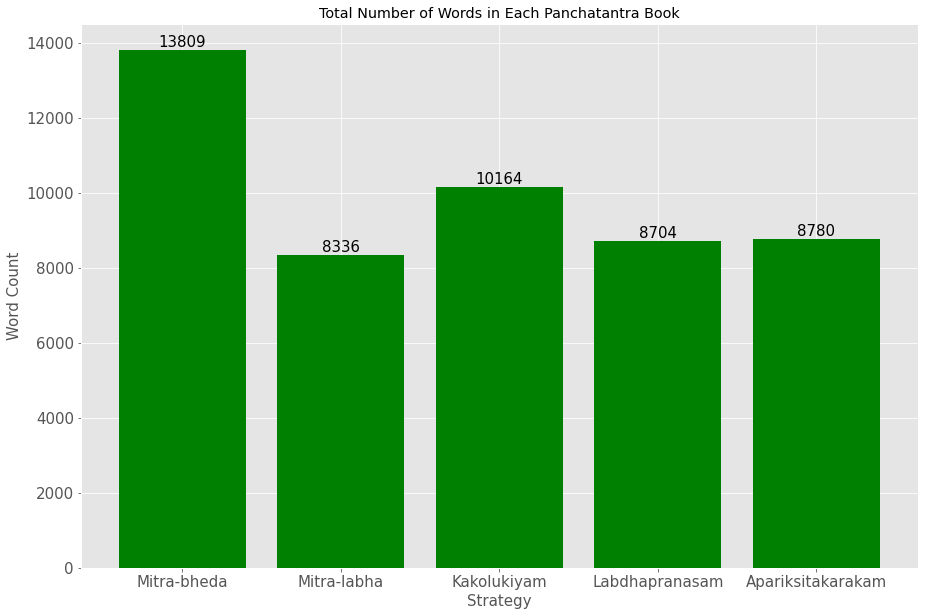

In [22]:
BookTitles=["Mitra-bheda", "Mitra-labha", 
            "Kakolukiyam", "Labdhapranasam",
           "Apariksitakarakam"]

x = df.groupby(['BookNumber'])['WordCount'].sum().reset_index()['BookNumber']
y = df.groupby(['BookNumber'])['WordCount'].sum().reset_index()['WordCount']

plt.style.use('ggplot')
barchart=plt.bar(x, y, color=['green'])
plt.xlabel("Strategy", fontsize = 15)
plt.ylabel("Word Count", fontsize = 15)
plt.title("Total Number of Words in Each Panchatantra Book")
plt.xticks(x, BookTitles)

    
for bar in barchart:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize = 15)


plt.savefig('Panchatantratotalwords.png')